In [24]:
#library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import solve_ivp
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression

In [2]:
#define parameters
n_species = 4
n_cs = 10 # cs = carbon sources

#default values
g = np.ones(n_species) # conversion factor from energy uptake to growth rate, for species i ## all 1's, so all the energy is converted into growth ?
m = np.zeros(n_species) # minimal energy uptake for maintenance of species (energy/time)
l = 0.1*np.ones((n_species, n_cs)) # leakage fractions for resource 'a' (unitless)
K = 1e-1*np.ones(n_cs) # consider making this small  ## WHAT IS THIS
w = np.ones(n_cs) # all metabolites have the same energy
d = 0.1 # dilution rate
c =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i
J = np.zeros((n_species, n_cs)) #energie intake d'in individu i par une ressource a
D = np.full((n_species, n_cs, n_cs),0.05) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)

In [3]:
N0 = [ # list of initial population densities
    1e-4, # species 1
    1e-4, # species 2
    1e-4, # species 3
    1e-4  # species 4
    ]
R0 = np.zeros(n_cs) # concentration of resources at t=0 (mass/volume)
R0[0] = 10 # first resource has a concentration of 10 (why ?) parce que après on va peut être obtenir les autres ressources grace aux byproduct
y0 = np.append(np.array(N0),R0)

In [4]:
#simplified model
def CR_model_simple(t, y):
  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0
  N[N<1e-6] = 0
  J = np.zeros((n_species, n_cs))
  for i in range(n_species):
    for a in range(n_cs):
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a])
  dNdt = np.zeros(n_species)
  for i in range(n_species):
    growth_intake = np.sum([J[i, a] for a in range(n_cs)])
    print(growth_intake, R[0])
    dNdt[i] = (N[i]*growth_intake)-(N[i]*d)

  dRdt = np.zeros(n_cs)
  for a in range(n_cs):
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)])
    dRdt[a] = (R0[a]-R[a])*d - consumption

  return np.concatenate((dNdt,dRdt))

In [5]:
# complete model
def CR_model(t, y):

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0
  N[N<1e-6] = 0
  J = np.zeros((n_species, n_cs))
  for i in range(n_species):
    for a in range(n_cs):
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a])

  dNdt = np.zeros(n_species)
  for i in range(n_species):
    growth_intake = np.sum([(J[i, a]*w[a]*(1-l[i,a]))-m[i]for a in range(n_cs)])
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d)

  dRdt = np.zeros(n_cs)
  for a in range(n_cs):
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)])
    byproduction_tot = np.zeros((n_species, n_cs))
    for i in range(n_species):
      for b in range(n_cs):
        byproduction_tot[i,b] = D[i,a,b]*w[b]*l[i,b]*N[i]*J[i,b]/w[a]
    byproduction = np.sum(byproduction_tot)
    dRdt[a] = (R0[a]-R[a])*d - consumption + byproduction

  return np.concatenate((dNdt,dRdt))

In [6]:
t_span = (0,300)
t_eval = np.linspace(t_span[0], t_span[1],300)

In [7]:
#solution of the model
solutions = solve_ivp(CR_model, t_span, y0, method = "BDF")

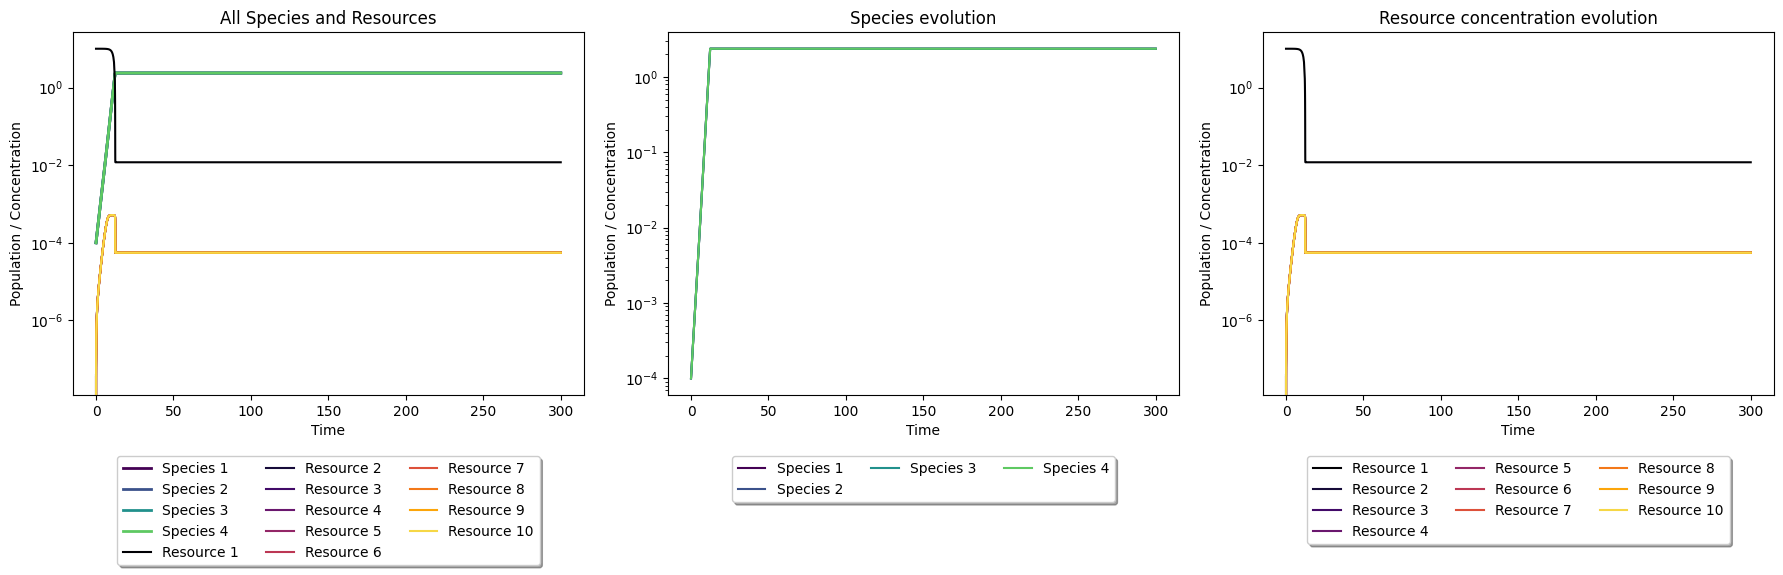

In [8]:
# better plot for solutions ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [9]:
#Randomisation of some parameters
c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs)) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)
c

array([[0.02507369, 0.17895663, 0.12370178, 0.4394792 , 0.58753847,
        0.98469104, 0.75976967, 0.21588329, 0.70771107, 0.9288196 ],
       [0.09521584, 0.58657279, 0.66163753, 0.88227512, 0.24011784,
        0.29047793, 0.58058685, 0.60195417, 0.12501368, 0.20027974],
       [0.69383816, 0.55912315, 0.51098117, 0.4059215 , 0.63144194,
        0.31566986, 0.33146985, 0.11212766, 0.66084288, 0.51512583],
       [0.56492345, 0.52127897, 0.99781343, 0.64451242, 0.14916223,
        0.34763042, 0.10380815, 0.45633966, 0.11852306, 0.06356147]])

In [10]:
t_span = (0,100000)
t_eval = np.linspace(t_span[0], t_span[1],300)
solutions2 = solve_ivp(CR_model, t_span, y0, method = "BDF")

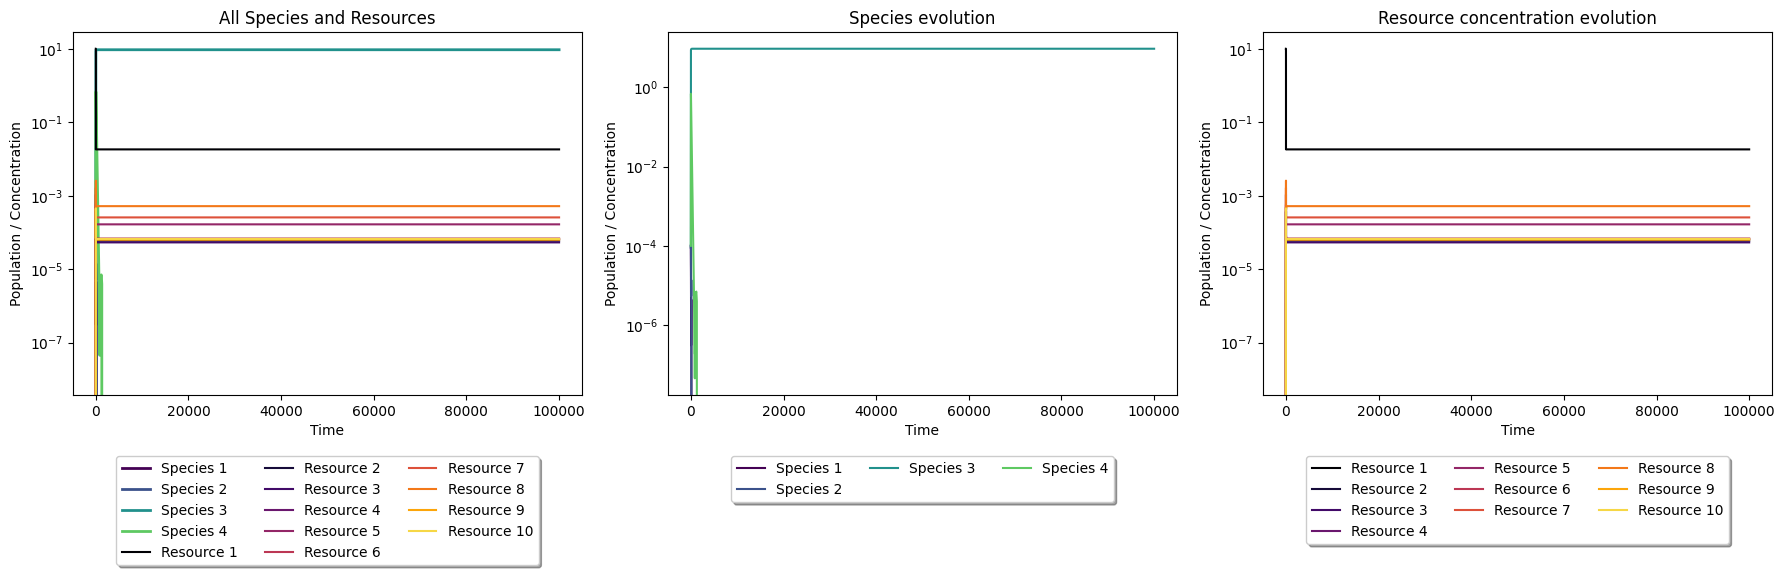

In [11]:
# better plot for solutions *2* ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [12]:
#random multiple simulations

sim_dict = {}
for i in range(1000):
  c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
  D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs))
  sol = solve_ivp(CR_model, t_span, y0, method = "BDF")
  sim_dict[f"simulation {i}"] = [[c,D],sol]


<ipython-input-28-4c5e08333ecd>:10: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


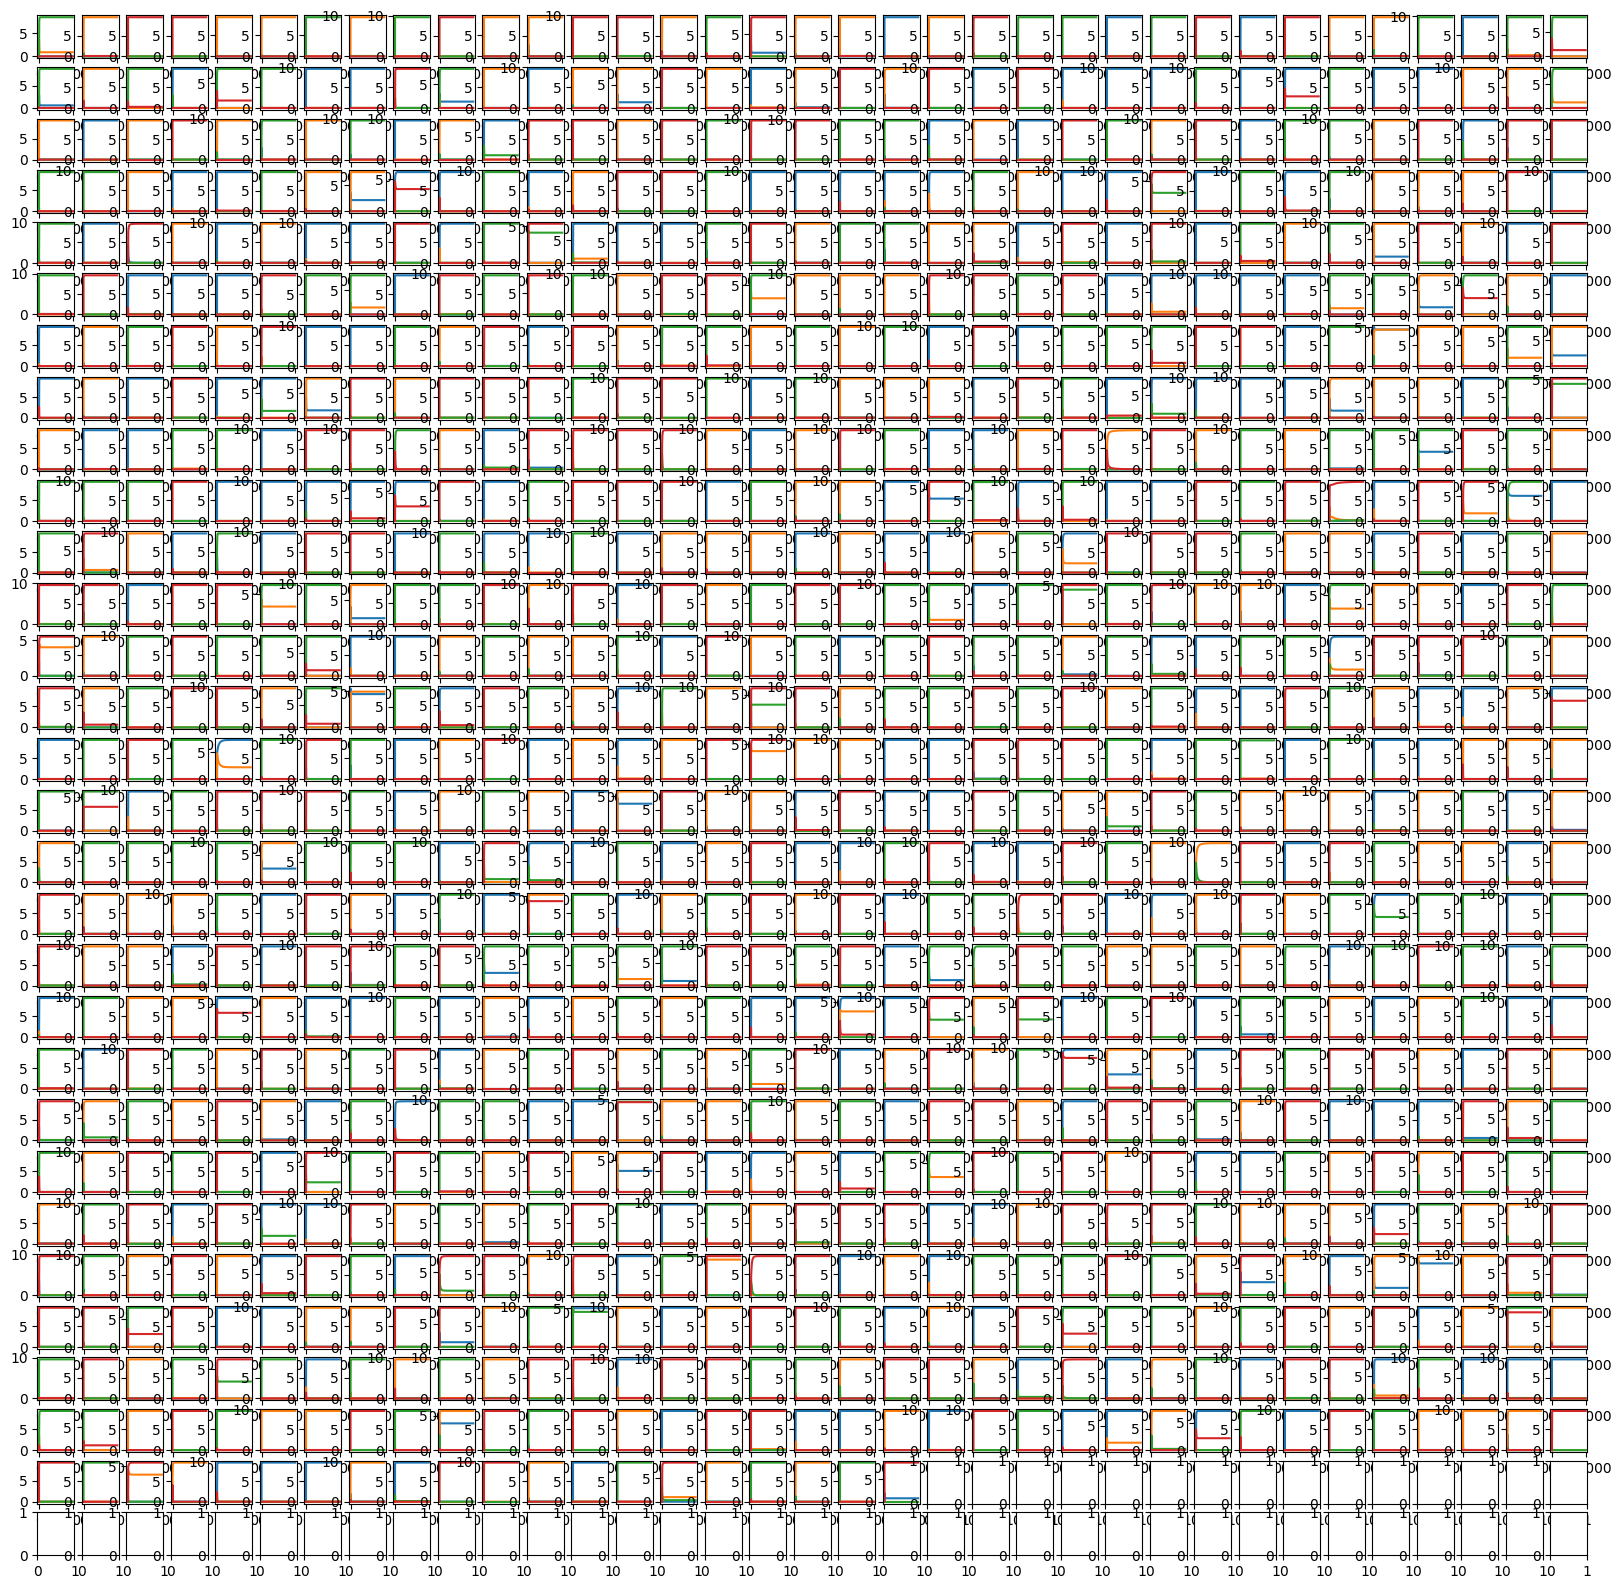

In [28]:
#plotting usinage

fig, axs = plt.subplots(30,35,figsize = (20,20))

for ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):
  ax.plot(value[1].t, value[1].y[0], label='Species 1')
  ax.plot(value[1].t, value[1].y[1], label='Species 2')
  ax.plot(value[1].t, value[1].y[2], label='Species 3')
  ax.plot(value[1].t, value[1].y[3], label='Species 4')  #ax.set_yscale("log")
plt.tight_layout()
plt.show()

In [14]:

cohabitation_data = {"sim":[], "c" :[], "D" : []}

domination_data = {"sim":[],"c":[], "D":[]}

for i in range(len(sim_dict)):
  index_alive = []
  for a in range(n_species):
    if sim_dict[f"simulation {i}"][1].y[a][-1:] > 1e-9:
      index_alive.append(a)
  if len(index_alive) > 1:
    cohabitation_data["sim"].append(f"simulation {i}")
    cohabitation_data["c"].append(sim_dict[f"simulation {i}"][0][0])
    cohabitation_data["D"].append(sim_dict[f"simulation {i}"][0][1])
  else:
    domination_data["sim"].append(f"simulation {i}")
    domination_data["c"].append(sim_dict[f"simulation {i}"][0][0])
    domination_data["D"].append(sim_dict[f"simulation {i}"][0][1])

cohabitation_df = pd.DataFrame(cohabitation_data)
domination_df = pd.DataFrame(domination_data)
domination_df.head()

,sim,c,D
0,simulation 1,"[[0.7471281587405214, 0.17450428712987964, 0.6...","[[[0.01083416780566694, 0.08610688705067872, 0..."
1,simulation 2,"[[0.108735818246818, 0.701405696910982, 0.0548...","[[[0.056125112561639046, 0.07134022973184766, ..."
2,simulation 3,"[[0.24766952419584753, 0.6477781468161521, 0.3...","[[[0.0912040447279216, 0.08892602744639488, 0...."
3,simulation 5,"[[0.5445079395704137, 0.5637683877595085, 0.57...","[[[0.08392574991566709, 0.06698282421643593, 0..."
4,simulation 6,"[[0.359582140887012, 0.5257597561297904, 0.997...","[[[0.06849562280046136, 0.025169876987422558, ..."


In [16]:
#enregistrement des datas

OSError: Cannot save file into a non-existent directory: 'C:/Users/besan/OneDrive/Bureau/Module 6'

In [29]:
# Statistical analysis

sum_cohab = np.array([i.flatten() for i in cohabitation_df["D"]])
sum_domi = np.array([i.flatten() for i in domination_df["D"]])
pca = PCA(n_components=5)
t_stat, p_value = mannwhitneyu(sum_cohab, sum_domi)
p_value

array([1.18047708e-01, 8.69919596e-01, 9.17139382e-01, 8.77654552e-01,
       3.68083105e-01, 9.14542856e-01, 3.72014256e-01, 4.19622307e-01,
       5.52815128e-01, 2.41542241e-01, 3.03067099e-01, 9.59219873e-01,
       9.92191937e-02, 9.93581200e-01, 1.53833185e-01, 5.96296681e-01,
       2.97468478e-01, 8.47646520e-01, 2.40994687e-01, 5.04484328e-01,
       9.53353808e-01, 3.68228241e-01, 1.25741209e-01, 3.00640976e-01,
       2.35890382e-01, 2.58032902e-01, 5.09547699e-01, 1.97889907e-01,
       3.69099801e-01, 3.73916281e-01, 7.84973551e-01, 1.10059161e-01,
       9.63467615e-03, 7.18561157e-01, 9.39242770e-01, 1.54700783e-01,
       8.45938000e-01, 1.07711960e-01, 5.80509296e-01, 6.40687188e-01,
       1.60959782e-01, 9.96844971e-01, 1.49936114e-01, 8.41968670e-03,
       8.56199707e-01, 9.11298484e-01, 4.12121128e-01, 6.74807001e-01,
       9.12596059e-01, 6.69038205e-01, 8.52562478e-01, 5.99136312e-01,
       7.21620653e-02, 2.62536043e-01, 2.60682078e-01, 3.46577489e-01,
      